## Impressions and Reviews  
- log data의 특성상 유입경로와 고객의 인구통계학적 정보(국적 등), os나 접속기기 등에 대해 파생변수를 다양하게 만들어 변수로 사용
- kfold + lgbm 을 통해 kfold별 test prediction값의 평균을 최종 제출
- y뿐 아니라 X 변수에도 log1p를 적극적으로 사용
- 데이터가 매우 큰 반면 메모리 관리를 안한 것이 아쉬움

## General information
This kernel is dedicated to EDA of Google Analytics Customer Revenue Prediction  competition as well as feature engineering. For now basic data is used and not data from BigQuery.

In this dataset we can see customers which went to Google Merchandise Store, info about them and their transactions. We need to predict the natural log of the sum of all transactions per user.

A continuation of this kernel can be found in [this one](https://www.kaggle.com/artgor/lgb-and-feature-generation) it has more features, CV calculation and other things.

In [1]:
import numpy as np 
import pandas as pd 
import json
import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error

In [2]:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
 
def load_df(csv_path='/content/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     nrows=10000, # ram문제로 일부만 load
                     dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [3]:
%%time
train = load_df("/content/train_v2.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 2.82 s, sys: 910 ms, total: 3.73 s
Wall time: 5.91 s


In [4]:
%%time
test = load_df("/content/test_v2.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3.05 s, sys: 433 ms, total: 3.48 s
Wall time: 5.96 s


In [5]:
# 결측치 대입
train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # (nan, false) : nan을 True로 대입
test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train['trafficSource.isTrueDirect'].fillna(False, inplace=True) # (nan, false) : nan을 True로 대입
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)

# 20171016 -> 2017-10-16 로 변경
train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

## Data exploration

Some of columns aren't available in this dataset, let's drop them.

In [6]:
# nunique=1인 columns drop
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

# # only one not null value
# train.drop(['trafficSource.campaignCode'], axis=1, inplace=True)
# print(f'Dropped {len(cols_to_drop)} columns.')

In [7]:
# float type으로 변환
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    train[col] = train[col].astype(float)

In [8]:
train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1.0,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1.0,1.0,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN,False,NaN,NaN,NaN,NaN,NaN,True
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6.0,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2.0,2.0,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,False,NaN,NaN,NaN,NaN,NaN,True
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1.0,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2.0,2.0,NaN,1,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1.0,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2.0,2.0,NaN,1,1,1,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,False,NaN,NaN,NaN,NaN,NaN,True
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1.0,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2.0,2.0,NaN,1,1,52,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,False,NaN,NaN,NaN,NaN,NaN,True


In [9]:
# 결측치 비율 파악
for col in train.columns:
    if train[col].isnull().sum() > 0:
        rate = train[col].isnull().sum() * 100 / train.shape[0]
        print(f'Column {col} has {rate:.4f}% missing values.')
    if train[col].dtype == 'object':
        if (train[col] == 'not available in demo dataset').sum() > 0:
            rate = (train[col] == 'not available in demo dataset').sum() * 100 / train.shape[0]
            print(f'Column {col} has {rate:.4f}% values not available in dataset.')

Column geoNetwork.region has 53.5100% values not available in dataset.
Column geoNetwork.metro has 53.5100% values not available in dataset.
Column geoNetwork.city has 53.5100% values not available in dataset.
Column totals.pageviews has 0.0100% missing values.
Column totals.bounces has 53.5500% missing values.
Column totals.newVisits has 24.8700% missing values.
Column totals.sessionQualityDim has 38.3300% missing values.
Column totals.timeOnSite has 46.5900% missing values.
Column totals.transactions has 98.9800% missing values.
Column totals.transactionRevenue has 99.0100% missing values.
Column totals.totalTransactionRevenue has 99.0100% missing values.
Column trafficSource.keyword has 56.6800% missing values.
Column trafficSource.referralPath has 67.2400% missing values.
Column trafficSource.adContent has 96.9400% missing values.
Column trafficSource.adwordsClickInfo.page has 95.7900% missing values.
Column trafficSource.adwordsClickInfo.slot has 95.7900% missing values.
Column tr

We can see several thing from this overview:
- less than 2% of all transactions bring revenue. This percentage is more or less reasonable;
- some columns have full representation only in BigQuery, so it is necessary to use it;
- traffic sourse in some cases is unknown, we'll need to find a way to fill these values;
- there several groups of features: visitor activity, geodata and device info, source of traffic;

## Feature analysis

### Revenue

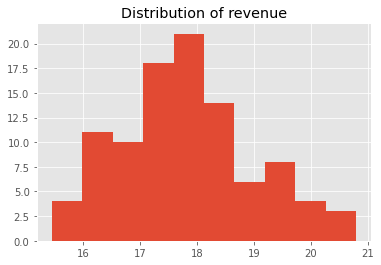

In [10]:
# revenue에 log1p 변환 - hist
plt.hist(np.log1p(train.loc[train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

Here we can see the distribution of transaction revenue. But it would be more useful to see a distribution of total revenue per user.

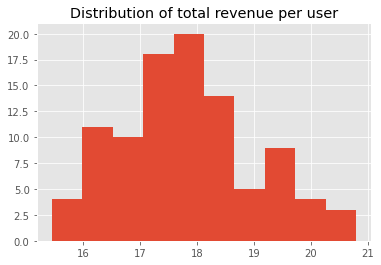

In [11]:
# fullVisitorId별 np.log(revenume sum) 결측치
grouped = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

The plots are quite similar.

In [12]:
# transaction이 있었던 data의 paid 횟수 탐색
counts = train.loc[train['totals.transactionRevenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(np.sum(counts == 1), 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of non-zero transactions per user:')
counts.head(10)

There are 98 paying users (9210 total) in train data.
97 users (98.9796% of paying) have 1 paid transaction.
1 users (1.0204% of paying) have 2 paid transaction.

Count of non-zero transactions per user:


0463325773564352787    2
9851027407827249742    1
8585031285178547027    1
4290831302541966980    1
205818826345710444     1
3741689406060673010    1
791462951878788065     1
6664733704830724714    1
8946514554986669717    1
9549089852095378957    1
Name: fullVisitorId, dtype: int64

Most paying users made only 1 transaction, but there are several users, who had a lot of transactions. Regular customers?

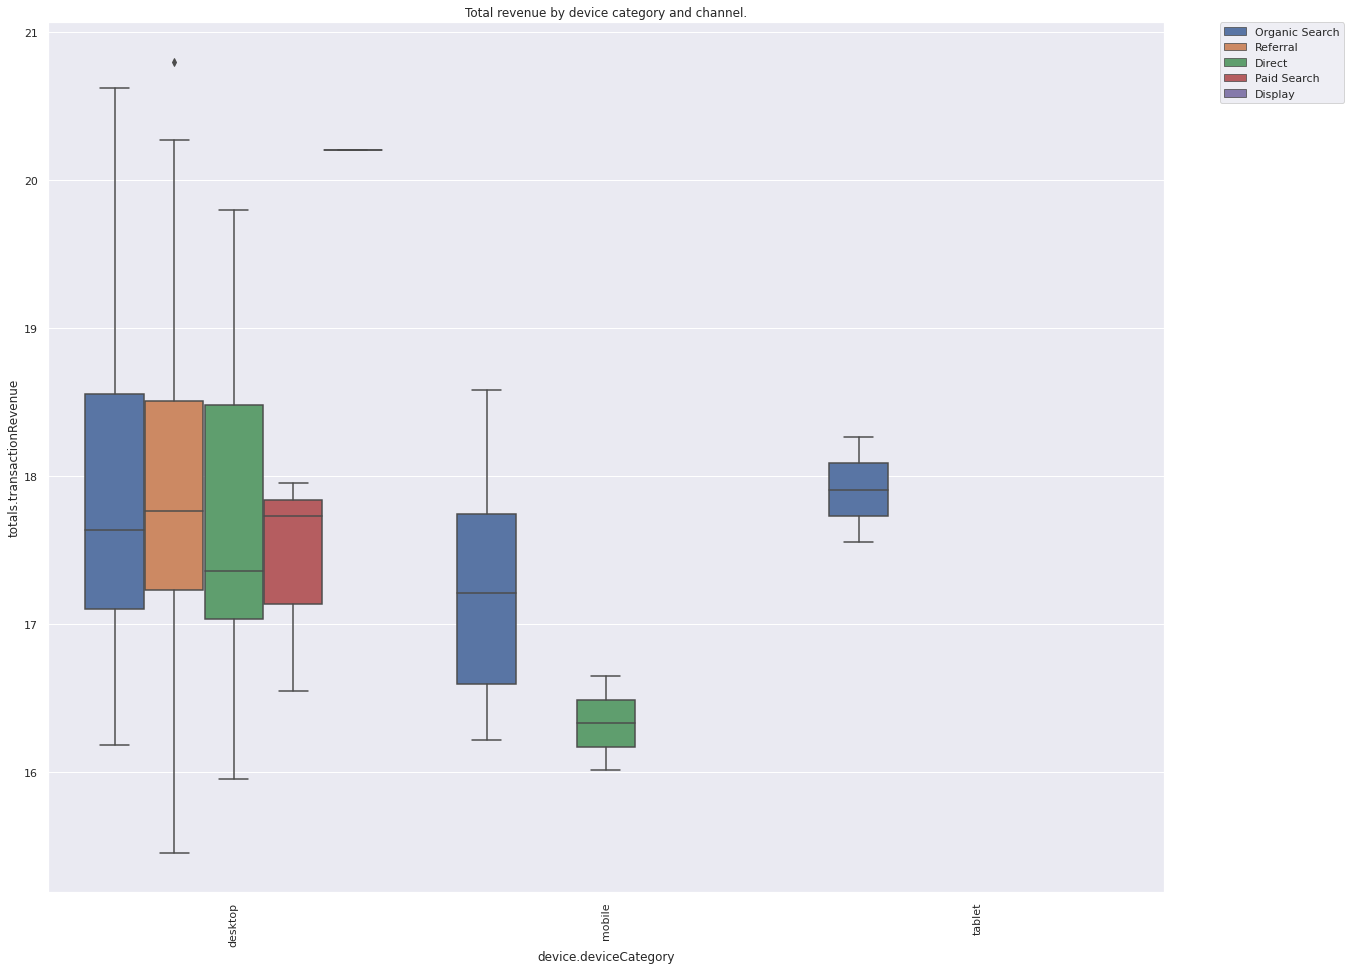

In [13]:
# device별 revenue boxplot - desktop most
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 16)})
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We can see that revenue comes mostly from desktops. Social, Affiliates and others aren't as profitable as other channels.

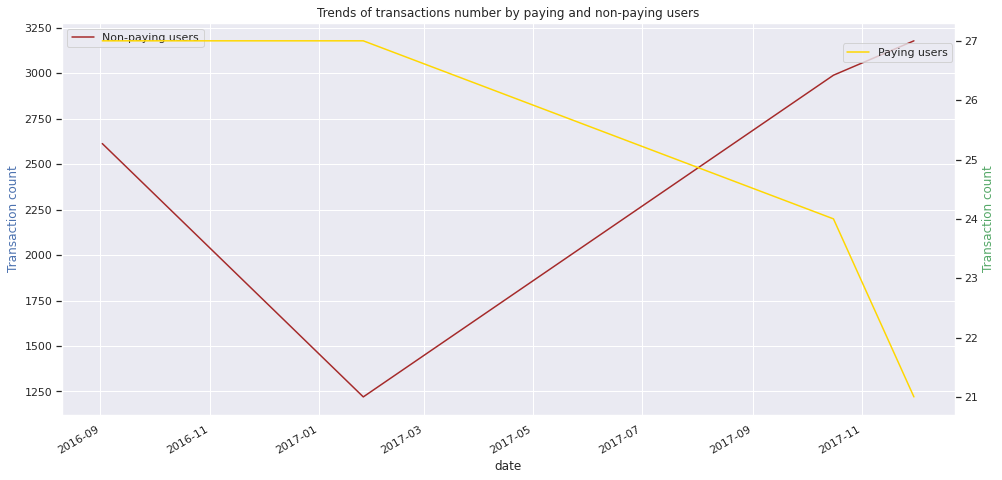

In [14]:
# 시간에 따른 paying user 변화
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of transactions number by paying and non-paying users");
train.groupby(['date'])['totals.transactionRevenue'].count().plot(color='brown')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Non-paying users'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='gold')
ax2.set_ylabel('Transaction count', color='g')
plt.legend(['Paying users'], loc=(0.875, 0.9))
plt.grid(False)

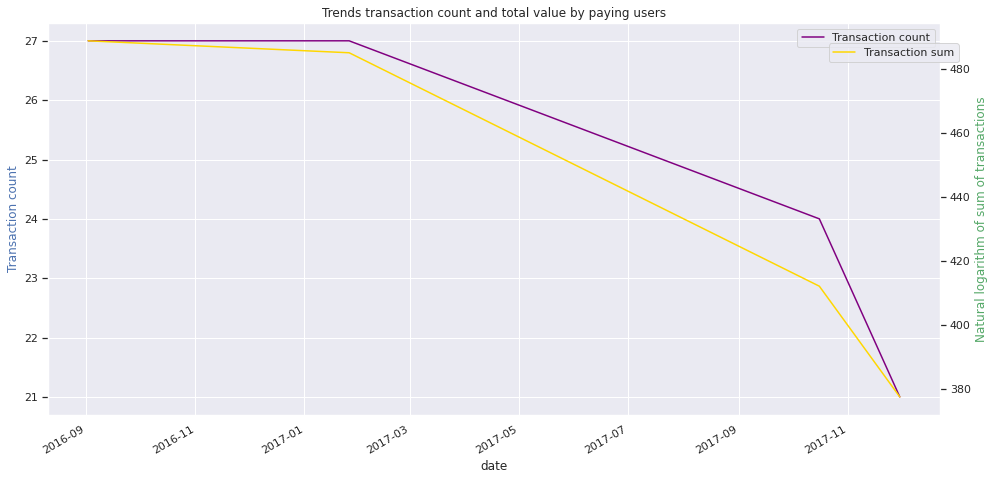

In [15]:
# 시간에 따른 transaction 수와 거래액 총합 - trend 유사
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends transaction count and total value by paying users")
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='purple')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Transaction count'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].sum().plot(color='gold')
ax2.set_ylabel('Natural logarithm of sum of transactions', color='g')
plt.legend(['Transaction sum'], loc=(0.875, 0.9))
plt.grid(False)

In [16]:
# 거래 기간 확인 - train기간과 test 기간은 상이
print(f'First date in train set is {train["date"].min()}. Last date in train set is {train["date"].max()}.')
print(f'First date in test set is {test["date"].min()}. Last date in test set is {test["date"].max()}.')

First date in train set is 2016-09-02 00:00:00. Last date in train set is 2017-11-30 00:00:00.
First date in test set is 2018-05-11 00:00:00. Last date in test set is 2018-09-18 00:00:00.



It isn't surprising that trends of sum and count of paid transactions are almost similar. It is worth noticing that there are several periods when the number of non-paying users was significantly higher that the number of paying users, but it didin't influence total sums.

Train and test period don't intersect.

### Devices

Let's see which devices bring most revenue!

Mean revenue per transaction


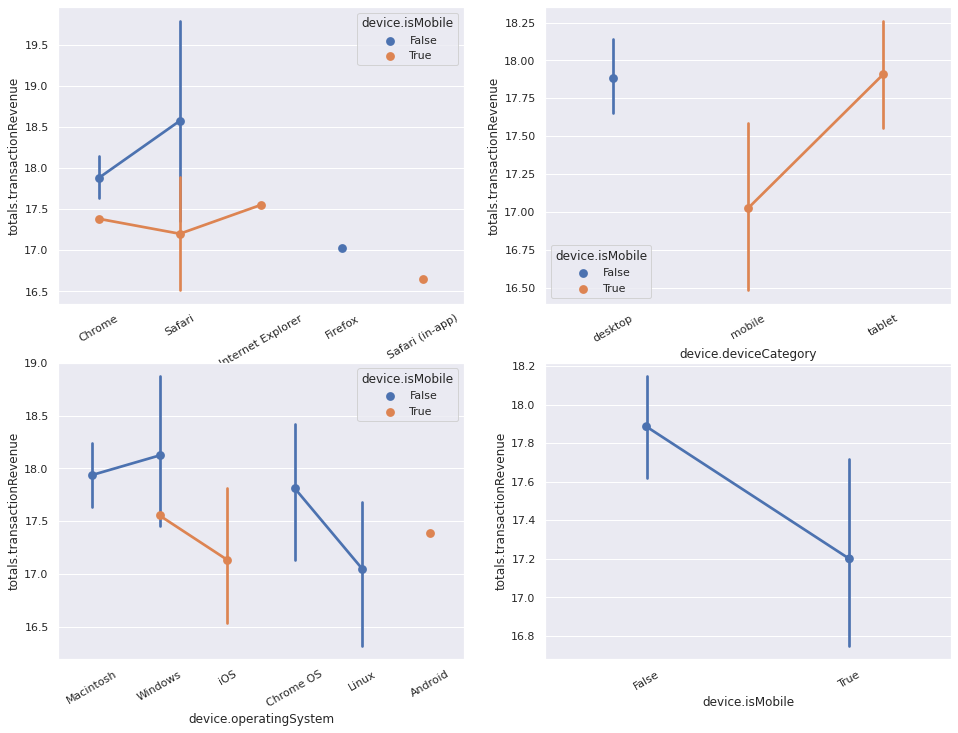

In [17]:
# device 브라우저, os 별 revenue : mac, chrome이 최대, desktop내에 mobile 요소들이 있다(특이점)
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
print('Mean revenue per transaction')
sns.pointplot(x="device.browser", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 0]);
sns.pointplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 1]);
sns.pointplot(x="device.operatingSystem", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[1, 0]);
sns.pointplot(x="device.isMobile", y="totals.transactionRevenue", data=train_, ax = ax[1, 1]);
ax[0, 0].xaxis.set_tick_params(rotation=30);
ax[0, 1].xaxis.set_tick_params(rotation=30);
ax[1, 0].xaxis.set_tick_params(rotation=30);
ax[1, 1].xaxis.set_tick_params(rotation=30);

It seems that devices on Chrome OS and Macs bring most profit.

There is an interesting fact - there are desktop devices which are considered to be mobile devices. Is it an error?

### geoNetwork

In [18]:
# column 값별로 revenue의 count와 mean : America에서 가장많다
def show_count_sum(df, col):
    return df.groupby(col).agg({'totals.transactionRevenue': ['count', 'mean']}).sort_values(('totals.transactionRevenue', 'count'), ascending=False).head()
show_count_sum(train_, 'geoNetwork.subContinent')

totals.transactionRevenue           
                                            count       mean
geoNetwork.subContinent                                     
Northern America                               98  17.810223
Southeast Asia                                  1  18.474601

Obviously most transactions come from America

In [19]:
# 'Northern America' 중 geoNetwork.metro 값별 revenue의 count와 mean
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.metro')

totals.transactionRevenue           
                                                      count       mean
geoNetwork.metro                                                      
San Francisco-Oakland-San Jose CA                        33  17.846583
not available in demo dataset                            30  17.884508
New York NY                                              16  17.983798
Chicago IL                                                7  18.161941
Detroit MI                                                3  17.897873

In [20]:
# 'Northern America' 중 geoNetwork.networkDomain 값별 revenue의 count와 mean
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.networkDomain')

totals.transactionRevenue           
                                             count       mean
geoNetwork.networkDomain                                     
(not set)                                       66  17.823557
comcast.net                                      5  18.386849
unknown.unknown                                  5  17.860907
purechat.com                                     2  18.291371
att.net                                          2  17.515788

In [21]:
# 'Northern America' 중 geoNetwork.region 값별 revenue의 count와 mean : CA 최대
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.region')

totals.transactionRevenue           
                                                  count       mean
geoNetwork.region                                                 
California                                           36  17.779020
not available in demo dataset                        30  17.884508
New York                                             16  17.983798
Illinois                                              7  18.161941
Michigan                                              3  17.897873

Most transactions are from California or New York.

### Traffic source

In [22]:
# trafficSource.medium 값별 revenue의 count와 mean
show_count_sum(train_, 'trafficSource.medium')

totals.transactionRevenue           
                                         count       mean
trafficSource.medium                                     
(none)                                      72  17.789930
organic                                     22  17.872552
cpc                                          3  17.409998
cpm                                          1  20.202238
referral                                     1  17.373142

Let's see how video ads influence revenue. There are for graphs, two of them show count of all users or only paying users, another two show mean and total revenue for transactions based on wheather there were video ads.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


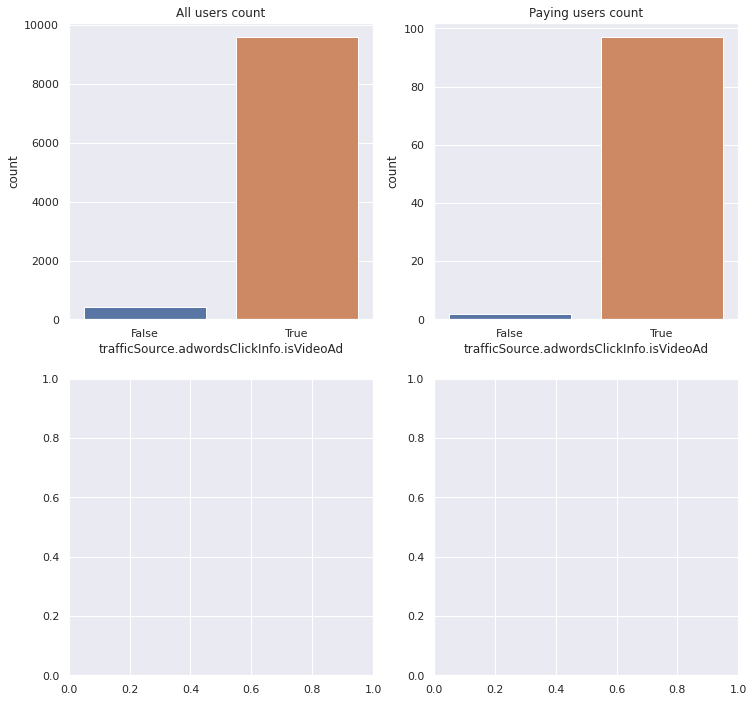

In [23]:
# videoad로 들어온 allusers와 paying users 수 파악
fig, ax = plt.subplots(2, 2, figsize = (12, 12));
sns.countplot('trafficSource.adwordsClickInfo.isVideoAd', data=train, ax = ax[0, 0]);
ax[0, 0].set_title('All users count');
sns.countplot('trafficSource.adwordsClickInfo.isVideoAd', data=train_, ax = ax[0, 1]);
ax[0, 1].set_title('Paying users count');

# trafficSource.adwordsClickInfo.isVideoAd 별 revenue mean과 sum
# train.groupby('trafficSource.adwordsClickInfo.isVideoAd')['totals.transactionRevenue'].mean().plot('bar', ax = ax[1, 0]);
# ax[1, 0].set_title('Mean revenue');
# train.groupby('trafficSource.adwordsClickInfo.isVideoAd')['totals.transactionRevenue'].sum().plot('bar', ax = ax[1, 1]);
# ax[1, 1].set_title('Total revenue');

We can see that the ratio of users arriving from video ads is almost the same for paid and non-paid transactions.

And total revenue from transactions from video ads is much higher.

Let's see the same graphs for trafficSource.adwordsClickInfo.isTrueDirect feature

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


TypeError: ignored

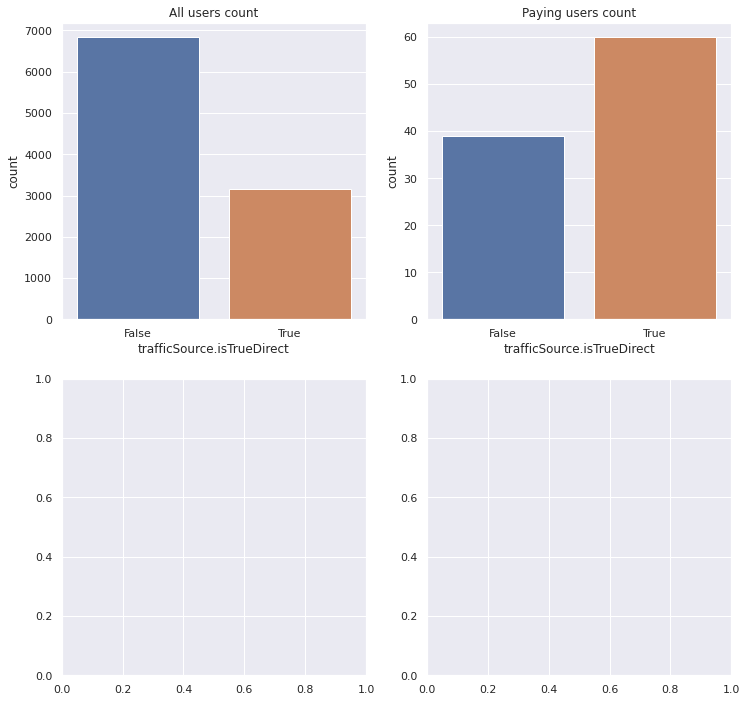

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12));
sns.countplot('trafficSource.isTrueDirect', data=train, ax = ax[0, 0]);
ax[0, 0].set_title('All users count');
sns.countplot('trafficSource.isTrueDirect', data=train_, ax = ax[0, 1]);
ax[0, 1].set_title('Paying users count');
# train.groupby('trafficSource.isTrueDirect')['totals.transactionRevenue'].mean().plot('bar', ax = ax[1, 0]);
# ax[1, 0].set_title('Mean revenue');
# train.groupby('trafficSource.isTrueDirect')['totals.transactionRevenue'].sum().plot('bar', ax = ax[1, 1]);
# ax[1, 1].set_title('Total revenue');

True directing seems to be better in all regards.

### Totals

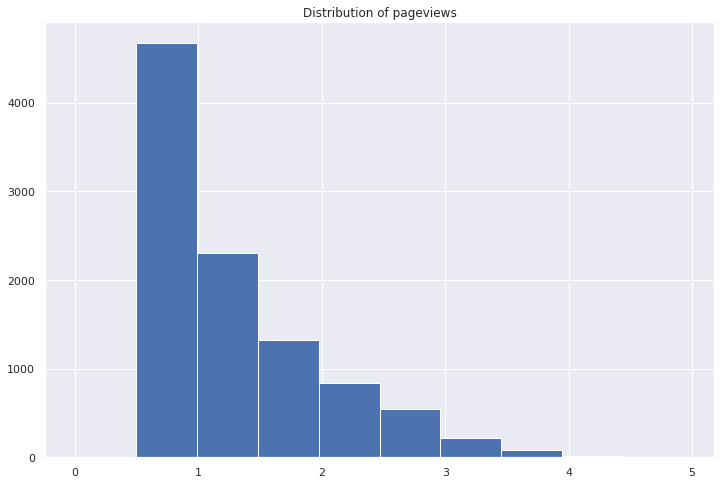

In [25]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of pageviews');
plt.hist(np.log1p(train['totals.pageviews'].fillna(0)));

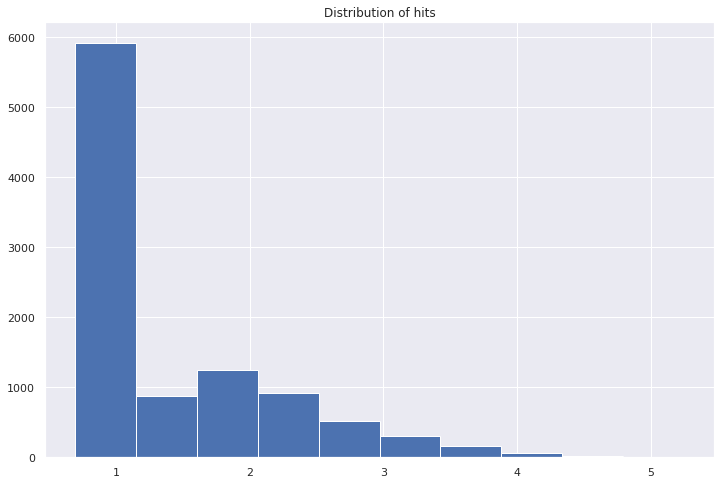

In [26]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of hits');
plt.hist(np.log1p(train['totals.hits'].fillna(0)));

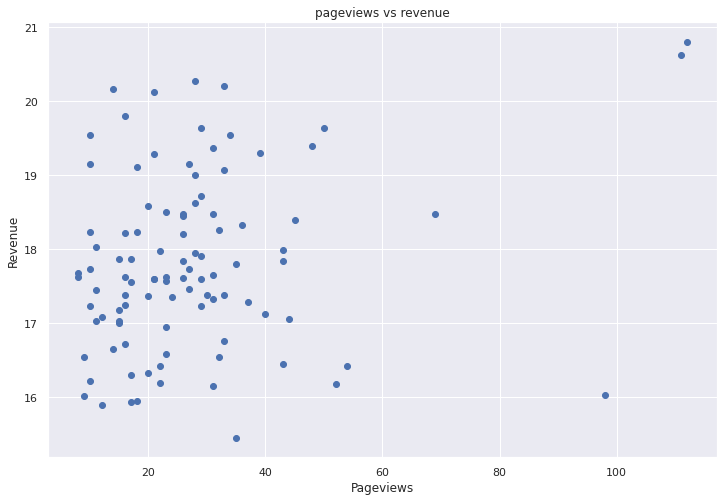

In [27]:
plt.figure(figsize=(12, 8))
plt.title('pageviews vs revenue');
plt.scatter(train_['totals.pageviews'], train_['totals.transactionRevenue']);
plt.xlabel('Pageviews');
plt.ylabel('Revenue');

## Feature engineering

At first let's create some features

In [28]:
del grouped, counts, train_

In [29]:
# mth, day, 주중번호, 연 주차번호
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday
train['weekofyear'] = train['date'].dt.weekofyear

# 시간별 unique id 개수를 각 row에 할당
train['month_unique_user_count'] = train.groupby('month')['fullVisitorId'].transform('nunique')
train['day_unique_user_count'] = train.groupby('day')['fullVisitorId'].transform('nunique')
train['weekday_unique_user_count'] = train.groupby('weekday')['fullVisitorId'].transform('nunique')
train['weekofyear_unique_user_count'] = train.groupby('weekofyear')['fullVisitorId'].transform('nunique')

# test에 동일
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['weekofyear'] = test['date'].dt.weekofyear

test['month_unique_user_count'] = test.groupby('month')['fullVisitorId'].transform('nunique')
test['day_unique_user_count'] = test.groupby('day')['fullVisitorId'].transform('nunique')
test['weekday_unique_user_count'] = test.groupby('weekday')['fullVisitorId'].transform('nunique')
test['weekofyear_unique_user_count'] = test.groupby('weekofyear')['fullVisitorId'].transform('nunique')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [30]:
# device 관련 컬럼 combine
train['browser_category'] = train['device.browser'] + '_' + train['device.deviceCategory']
train['browser_operatingSystem'] = train['device.browser'] + '_' + train['device.operatingSystem']

test['browser_category'] = test['device.browser'] + '_' + test['device.deviceCategory']
test['browser_operatingSystem'] = test['device.browser'] + '_' + test['device.operatingSystem']

train['source_country'] = train['trafficSource.source'] + '_' + train['geoNetwork.country']
test['source_country'] = test['trafficSource.source'] + '_' + test['geoNetwork.country']

In [31]:
# log1p변환 
train['visitNumber'] = np.log1p(train['visitNumber'])
test['visitNumber'] = np.log1p(test['visitNumber'])

train['totals.hits'] = np.log1p(train['totals.hits'])
test['totals.hits'] = np.log1p(test['totals.hits'].astype(int))

train['totals.pageviews'] = np.log1p(train['totals.pageviews'].fillna(0))
test['totals.pageviews'] = np.log1p(test['totals.pageviews'].astype(float).fillna(0))

# network_domain, 시간에 따른 total pageviews, hits의 통계값 사용
train['sum_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
train['count_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
train['mean_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
train['sum_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
train['count_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
train['mean_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

test['sum_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
test['count_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
test['mean_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
test['sum_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
test['count_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
test['mean_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

train['mean_hits_per_day'] = train.groupby(['day'])['totals.hits'].transform('mean')
train['sum_hits_per_day'] = train.groupby(['day'])['totals.hits'].transform('sum')
test['mean_hits_per_day'] = test.groupby(['day'])['totals.hits'].transform('mean')
test['sum_hits_per_day'] = test.groupby(['day'])['totals.hits'].transform('sum')

In [32]:
# region 따른 total pageviews, hits의 통계값 사용
train['sum_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
train['count_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
train['mean_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')

train['sum_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('sum')
train['count_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('count')
train['mean_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('mean')

test['sum_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
test['count_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
test['mean_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')

test['sum_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('sum')
test['count_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('count')
test['mean_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('mean')

In [33]:
# country별 total pageview, hits 통계값 사용
train['sum_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
train['count_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
train['mean_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

train['sum_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('sum')
train['count_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('count')
train['mean_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('mean')

train['sum_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('sum')
train['count_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('count')
train['mean_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('mean')

test['sum_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
test['count_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
test['mean_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

test['sum_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('sum')
test['count_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('count')
test['mean_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('mean')

test['sum_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('sum')
test['count_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('count')
test['mean_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('mean')

In [34]:
# id별 total pageview, hits 통계값 사용
train['user_pageviews_sum'] = train.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
train['user_hits_sum'] = train.groupby('fullVisitorId')['totals.hits'].transform('sum')
test['user_pageviews_sum'] = test.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
test['user_hits_sum'] = test.groupby('fullVisitorId')['totals.hits'].transform('sum')

train['user_pageviews_count'] = train.groupby('fullVisitorId')['totals.pageviews'].transform('count')
train['user_hits_count'] = train.groupby('fullVisitorId')['totals.hits'].transform('count')
test['user_pageviews_count'] = test.groupby('fullVisitorId')['totals.pageviews'].transform('count')
test['user_hits_count'] = test.groupby('fullVisitorId')['totals.hits'].transform('count')

train['user_pageviews_sum_to_mean'] = train['user_pageviews_sum'] / train['user_pageviews_sum'].mean()
train['user_hits_sum_to_mean'] = train['user_hits_sum'] / train['user_hits_sum'].mean()
test['user_pageviews_sum_to_mean'] = test['user_pageviews_sum'] / test['user_pageviews_sum'].mean()
test['user_hits_sum_to_mean'] = test['user_hits_sum'] / test['user_hits_sum'].mean()

In [35]:
# 지역별 pageview, hits 비율
train['user_pageviews_to_region'] = train['user_pageviews_sum'] / train['mean_pageviews_per_region']
train['user_hits_to_region'] = train['user_hits_sum'] / train['mean_hits_per_region']

test['user_pageviews_to_region'] = test['user_pageviews_sum'] / test['mean_pageviews_per_region']
test['user_hits_to_region'] = test['user_hits_sum'] / test['mean_hits_per_region']

### Feature processing

In [36]:
# columns 분류
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'month_unique_user_count', 'day_unique_user_count', 'mean_hits_per_day'
           'sum_pageviews_per_network_domain', 'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'sum_hits_per_region',
           'sum_hits_per_day', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain', 'weekday_unique_user_count',
           'sum_pageviews_per_region', 'count_pageviews_per_region', 'mean_pageviews_per_region', 'user_pageviews_count', 'user_hits_count',
           'count_hits_per_region', 'mean_hits_per_region', 'user_pageviews_sum', 'user_hits_sum', 'user_pageviews_sum_to_mean',
            'user_hits_sum_to_mean', 'user_pageviews_to_region', 'user_hits_to_region', 'mean_pageviews_per_network_domain',
           'mean_hits_per_network_domain']

no_use = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']
cat_cols = [col for col in train.columns if col not in num_cols and col not in no_use]

In [ ]:
# train + test 의 cat_cols를 'str'로 변환 뒤 label_encoding 
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

channelGrouping
customDimensions
hits


In [ ]:
# date 별로 정렬후 X, y 정의
train = train.sort_values('date')
X = train.drop(no_use, axis=1)
y = train['totals.transactionRevenue']
X_test = test.drop([col for col in no_use if col in test.columns], axis=1)
# I use TimeSeriesSplit as we have time series
tscv = TimeSeriesSplit(n_splits=10)

In fact it seems that it will take some time to find a good validation - TimeSeriesSplit gives a high variance in scores, so I'll try kfold for now.

In [ ]:
params = {"objective" : "regression", "metric" : "rmse", "max_depth": 8, "min_child_samples": 20, "reg_alpha": 0.2, "reg_lambda": 0.2,
        "num_leaves" : 257, "learning_rate" : 0.01, "subsample" : 0.9, "colsample_bytree" : 0.9, "subsample_freq ": 5}
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [ ]:
# lgbm + kfold (mean prediction) 사용
prediction = np.zeros(test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    #print(f'Train samples: {len(train_index)}. Valid samples: {len(test_index)}')
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred

# testset에 대한 n_fold별 예측값의 평균을 submit
prediction /= n_fold

In [ ]:
lgb.plot_importance(model, max_num_features=30);

Previously I made a submission following the officially suggested logic: calculating logarithm of sum of predicted revenues. But some people say that it is better to simply submit the sum of predicted values (which are already logarithms). Let's try!

In [ ]:
# test["PredictedLogRevenue"] = np.expm1(prediction)
# sub = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
# sub["PredictedLogRevenue"] = np.log1p(sub["PredictedLogRevenue"])
# sub["PredictedLogRevenue"] = sub["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
# sub["PredictedLogRevenue"] = sub["PredictedLogRevenue"].fillna(0.0)
# sub.to_csv("lgb.csv", index=False)


# from this kernel: https://www.kaggle.com/fabiendaniel/lgbm-rf-starter-lb-1-70
submission = test[['fullVisitorId']].copy()
#submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)
submission.loc[:, 'PredictedLogRevenue'] = prediction
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
#grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test.to_csv('lgb.csv',index=False)